In [7]:
# notebooks/spam_classifier.ipynb

import pandas as pd

# Load the dataset
df = pd.read_csv('../data/raw/spam.csv', encoding='latin-1')

# Show first 5 rows
df.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [8]:
# Keep only the needed columns
df = df[['v1', 'v2']]
df.columns = ['label', 'message']
df.head()


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label_num'] = le.fit_transform(df['label'])  # spam=1, ham=0


In [15]:
import string
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['clean_message'] = df['message'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/suryeshpandey/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
from sklearn.model_selection import train_test_split

X = df['clean_message']
y = df['label_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Train model
lr_model = LogisticRegression()
lr_model.fit(X_train_vec, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test_vec)


In [19]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_vec, y_train)

y_pred_dt = dt_model.predict(X_test_vec)


In [25]:
def evaluate_model(y_true, y_pred, model_name, filename):
    from sklearn.metrics import confusion_matrix, classification_report
    import seaborn as sns
    import matplotlib.pyplot as plt

    print(f"📊 {model_name} Metrics\n")
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(f'../visuals/plots/{filename}')
    plt.close()


In [26]:
evaluate_model(y_test, y_pred_lr_best, "Logistic Regression (Tuned)", "confusion_logistic.png")
evaluate_model(y_test, y_pred_dt_best, "Decision Tree (Tuned)", "confusion_dt.png")


📊 Logistic Regression (Tuned) Metrics

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.97      0.84      0.90       150

    accuracy                           0.97      1115
   macro avg       0.97      0.92      0.94      1115
weighted avg       0.97      0.97      0.97      1115

Confusion Matrix:
📊 Decision Tree (Tuned) Metrics

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       965
           1       0.85      0.80      0.82       150

    accuracy                           0.95      1115
   macro avg       0.91      0.89      0.90      1115
weighted avg       0.95      0.95      0.95      1115

Confusion Matrix:


In [27]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

y_probs_lr = grid_lr.best_estimator_.predict_proba(X_test_vec)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs_lr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.savefig("../visuals/plots/roc_curve.png")
plt.close()


🔍 Best Params (LR): {'C': 10, 'solver': 'lbfgs'}
Best F1 Score (CV): 0.8952405348467083
📊 Logistic Regression (Tuned) Metrics

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.97      0.84      0.90       150

    accuracy                           0.97      1115
   macro avg       0.97      0.92      0.94      1115
weighted avg       0.97      0.97      0.97      1115

Confusion Matrix:


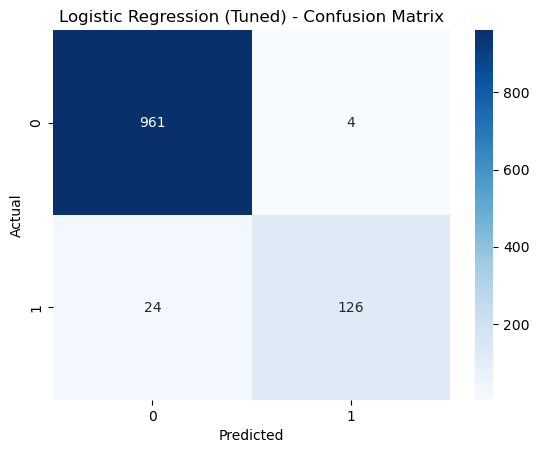

In [22]:
from sklearn.model_selection import GridSearchCV

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

grid_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_lr.fit(X_train_vec, y_train)

print("🔍 Best Params (LR):", grid_lr.best_params_)
print("Best F1 Score (CV):", grid_lr.best_score_)

# Predict using best estimator
y_pred_lr_best = grid_lr.best_estimator_.predict(X_test_vec)
evaluate_model(y_test, y_pred_lr_best, "Logistic Regression (Tuned)")


🔍 Best Params (DT): {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 5}
Best F1 Score (CV): 0.8355875997508772
📊 Decision Tree (Tuned) Metrics

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       965
           1       0.85      0.80      0.82       150

    accuracy                           0.95      1115
   macro avg       0.91      0.89      0.90      1115
weighted avg       0.95      0.95      0.95      1115

Confusion Matrix:


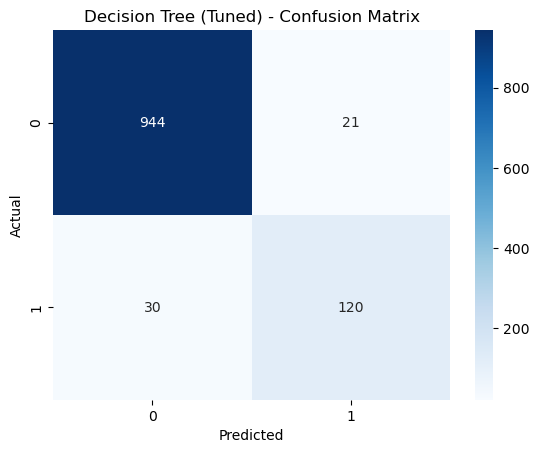

In [23]:
param_grid_dt = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5, scoring='f1', n_jobs=-1)
grid_dt.fit(X_train_vec, y_train)

print("🔍 Best Params (DT):", grid_dt.best_params_)
print("Best F1 Score (CV):", grid_dt.best_score_)

y_pred_dt_best = grid_dt.best_estimator_.predict(X_test_vec)
evaluate_model(y_test, y_pred_dt_best, "Decision Tree (Tuned)")


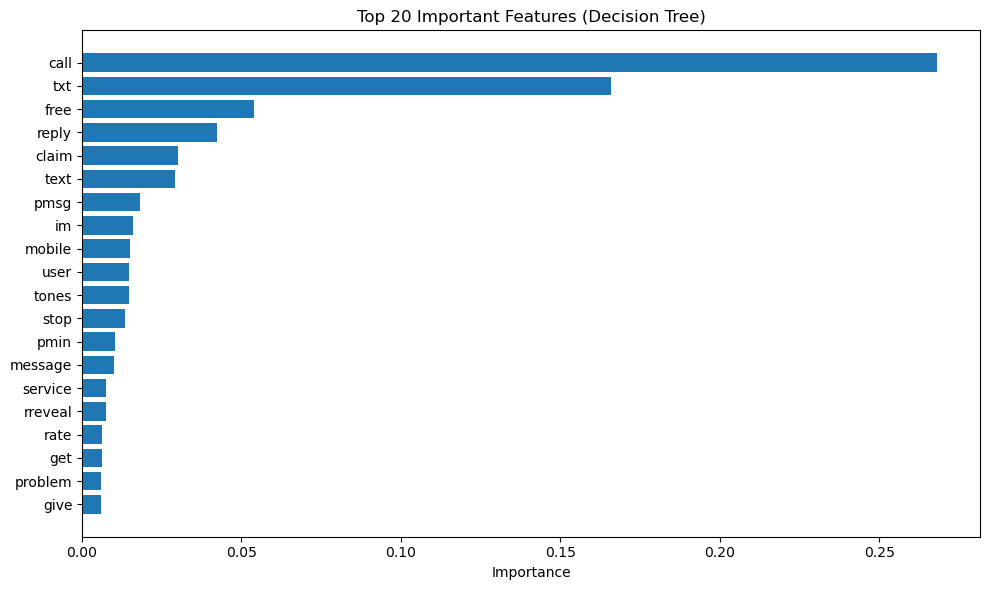

In [24]:
import numpy as np
import matplotlib.pyplot as plt

feature_names = vectorizer.get_feature_names_out()
importances = grid_dt.best_estimator_.feature_importances_
indices = np.argsort(importances)[-20:]

plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importance')
plt.title('Top 20 Important Features (Decision Tree)')
plt.tight_layout()
plt.savefig("../visuals/plots/feature_importance.png")
plt.close()
